# View QRNN predictions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import os
from datetime import datetime
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../visualize')
from sample_plots import plotRandomSample
sys.path.append('../src')

from quantnn.qrnn import QRNN
from quantnn.models.pytorch.logging import TensorBoardLogger
from quantnn.metrics import ScatterPlot
from load_data import GOESRETRIEVALSDataset, Mask, RandomSmallVals, RandomCrop, Standardize, ToTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cpu


In [2]:
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [3]:
def importData(BATCH_SIZE, path_to_data, path_to_stats, channel_inds, isTrain=False):

	transforms_list = [Mask(), RandomSmallVals()]
	if isTrain:
		transforms_list.append(RandomCrop(128))
	transforms_list.extend([Standardize(path_to_stats, channel_inds), ToTensor()])
	
	dataset = GOESRETRIEVALSDataset(
		path_to_data=path_to_data, 
		channel_inds=channel_inds,
		transform=transforms.Compose(transforms_list))
	print('number of samples:', len(dataset))

	#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
	return(dataset)#, dataloader)

In [4]:
channel_inds = list(range(0,8))
CHANNELS = list(range(8,17))
CHANNELS.remove(12)
channels = [CHANNELS[c] for c in channel_inds]

path_to_val_data_files = os.path.join(path_to_dataset,'data/dataset-boxes/validation/npy_files/')
path_to_stats =  os.path.join(path_to_dataset, 'data', 'stats.npy')
    
validation_dataset  = importData(None, path_to_val_data_files, path_to_stats, channel_inds)

number of samples: 1354


In [20]:
data_type = 'boxes'
path_to_model = '../results/models/xception64_[100]_0.01__boxes_100_0.01_0_t5412_v1354[0, 1, 2, 3, 4, 5, 6, 7]_Adam_1622288705.386947.pckl'
xception = QRNN.load(path_to_model)
BATCH_SIZE = 64

'/export/home/ingrid/Dendrite/UserAreas/Ingrid/data/dataset-boxes/validation/npy_files/GPMGOES-oS2019-12-31T21:29:42-c[8,9,10,11,13,14,15,16]-p256-b0.npy'

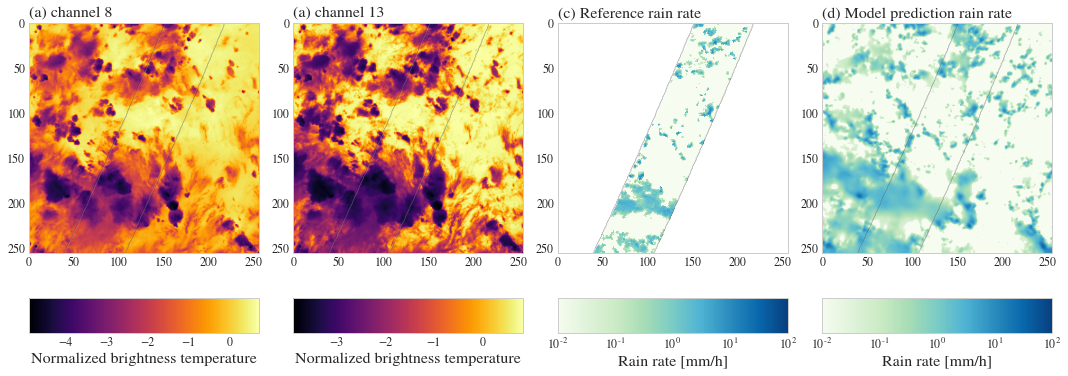

In [21]:
# PLOT RANDOM SAMPLE
idx = plotRandomSample(validation_dataset, channels, qrnn=xception, data_type=data_type)
validation_dataset.getfilename(idx)

In [22]:
data_type = 'singles'
path_to_model = '../results/models/singles_fc32786_[100]_0.001__singles_100_0.001_0_t83360758_v20805499[0, 1, 2, 3, 4, 5, 6, 7]_Adam_1622293711.867882.pckl'    
mlp = QRNN.load(path_to_model)
BATCH_SIZE = 32786

'/export/home/ingrid/Dendrite/UserAreas/Ingrid/data/dataset-boxes/validation/npy_files/GPMGOES-oS2019-12-31T21:29:42-c[8,9,10,11,13,14,15,16]-p256-b0.npy'

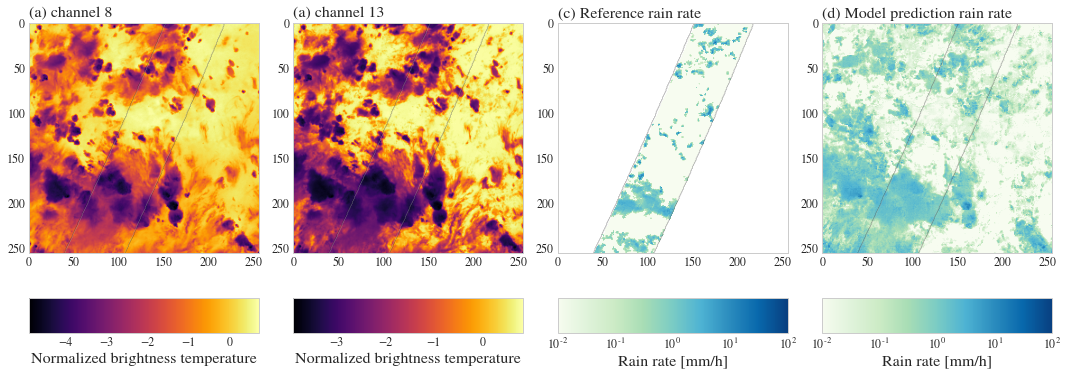

In [23]:
# PLOT RANDOM SAMPLE
idx = plotRandomSample(validation_dataset, channels, qrnn=mlp, index=idx, data_type=data_type)
validation_dataset.getfilename(idx)

In [24]:
print((validation_dataset[1]['box']).dtype)

torch.float32


In [25]:
import matplotlib
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [26]:
SMALL_SIZE = 12 #8
MEDIUM_SIZE = 16 #10
BIGGER_SIZE = 18 #12
matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import LogNorm

big = cm.get_cmap('magma', 512)
newcmp = ListedColormap(big(np.linspace(0.05, 0.95, 256)))

In [28]:
dataset = validation_dataset

In [33]:
index = np.random.randint(len(dataset))

In [34]:
data = dataset[index]
figsize=(9,6)

In [35]:
vmin = np.min(data['box'].numpy())
vmax = np.max(data['box'].numpy())

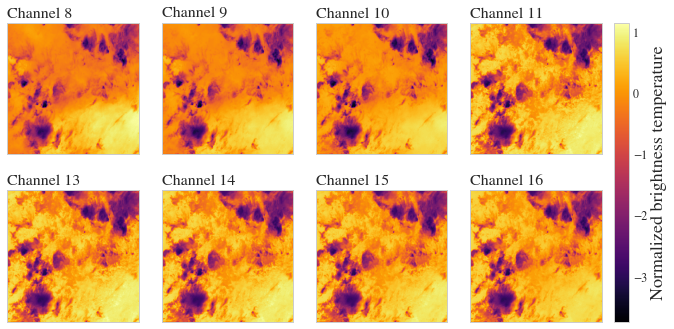

In [42]:

f, ax = plt.subplots(2, 4, figsize=figsize)
i=0
for c in channel_inds:
    m = ax[i, c%4].imshow(data['box'].numpy()[c], cmap=plt.get_cmap('inferno'), 
                         vmin=vmin, vmax=vmax)
    #ax.contour(y_true!=-1,  cmap=plt.get_cmap('binary_r'),  alpha = 0.7, linewidths=0.2)
    ax[i, c%4].grid(False)
    ax[i, c%4].set_title("Channel "+str(channels[c]), loc="left")
    ax[i, c%4].get_xaxis().set_ticks([])
    ax[i, c%4].get_yaxis().set_ticks([])
    #plt.axis('off')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.07)
    #plt.colorbar(m, cax=cax)
    #plt.tight_layout()
    if c==3:
        i+=1
        
f.tight_layout(h_pad=-4, w_pad=2)
f.colorbar(m, ax=ax, fraction=0.024, pad=0.02).set_label(label="Normalized brightness temperature", size=18)
#plt.savefig('../plots/thesis/ex_channels.pdf', bbox_inches='tight')

In [40]:


y_true = data['label'].numpy()

y_pred_b = torch.squeeze(xception.posterior_mean(x=data['box'].unsqueeze(0).to(device))).cpu().detach().numpy()

x = data['box'].unsqueeze(0).to(device)
X = torch.transpose(torch.squeeze(torch.flatten(x, start_dim=2)), 0, 1)
y_pred_s = mlp.posterior_mean(X).cpu().detach()
y_pred_s = torch.reshape(y_pred_s, (int(np.sqrt(y_pred_s.shape[0])), int(np.sqrt(y_pred_s.shape[0])))).numpy()


print(np.max(y_true), np.max(y_pred_b), np.max(y_pred_s))
precip_norm = LogNorm(1e-2, 1e2)

19.192017 21.809578 5.2165813


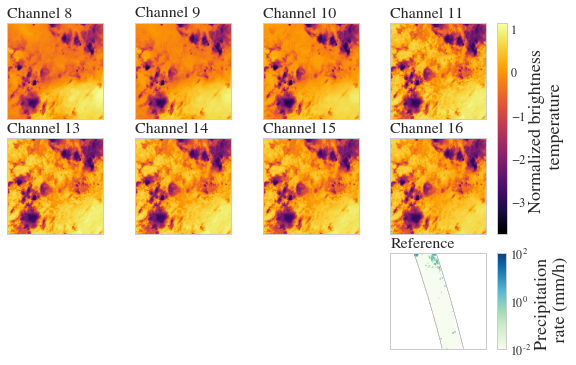

In [165]:

f, ax = plt.subplots(3, 4, figsize=figsize)

i=0
for c in channel_inds:
    m = ax[i, c%4].imshow(data['box'].numpy()[c], cmap=plt.get_cmap('inferno'), 
                         vmin=vmin, vmax=vmax)
    ax[i, c%4].grid(False)
    ax[i, c%4].set_title("Channel "+str(channels[c]), loc="left")
    ax[i, c%4].get_xaxis().set_ticks([])
    ax[i, c%4].get_yaxis().set_ticks([])
    if c==3:
        i+=1
        
#f.tight_layout(h_pad=1, w_pad=-30)
f.colorbar(m, ax=ax[:2], fraction=
           0.025,#0.024, 
           pad=0.0).set_label(label="Normalized brightness \n temperature", wrap=True, size=18)

n = ax[2,3].imshow(y_true, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
ax[2,3].contour(y_true!=-1,  cmap=plt.get_cmap('binary_r'),  alpha = 0.7, linewidths=0.1)
ax[2,3].grid(False)
ax[2,3].get_xaxis().set_ticks([])
ax[2,3].get_yaxis().set_ticks([])
ax[2,3].set_title("Reference", loc="left")
#f.tight_layout(h_pad=1, w_pad=2)
f.colorbar(n, ax=ax[2], fraction=0.025, pad=0, aspect=10).set_label(label="Precipitation \n rate (mm/h)", wrap=True, size=18)
ax[2, 1].axis('off')
ax[2, 2].axis('off')
ax[2, 0].axis('off')

for i in range(4):
    ax[0,i].set_anchor('W')
    ax[1,i].set_anchor('W')
    ax[2,i].set_anchor('W')

#f.tight_layout(h_pad=1, w_pad=1)

#plt.savefig('../plots/thesis/ex_channels.pdf', bbox_inches='tight')

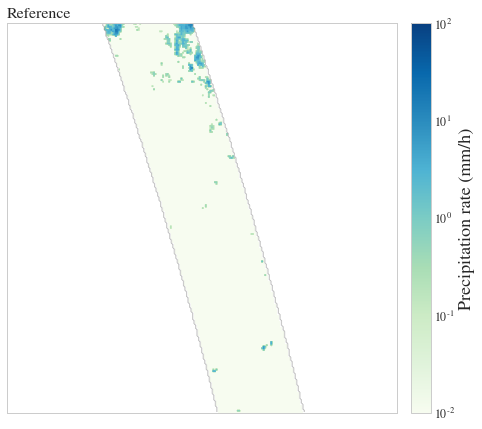

In [56]:
f, ax = plt.subplots(figsize=figsize)

m = ax.imshow(y_true, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
#ax.imshow(y_true!=-1,  cmap=plt.get_cmap('binary_r'), alpha = 0.1)
ax.contour(y_true!=-1,  cmap=plt.get_cmap('binary_r'),  alpha = 0.7, linewidths=0.1)
ax.grid(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title("Reference", loc="left")
f.tight_layout(h_pad=1, w_pad=2)
f.colorbar(m, ax=ax, fraction=0.032, pad=0.023).set_label(label="Precipitation rate (mm/h)", size=18)
#plt.savefig('../plots/thesis/ex_true.pdf', bbox_inches='tight')

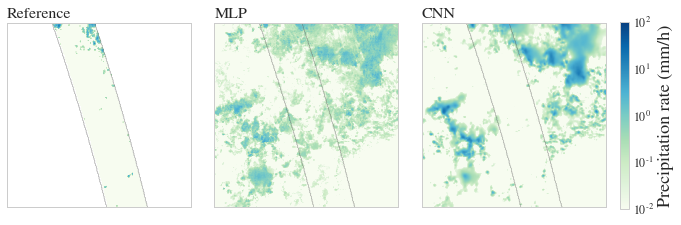

In [41]:
f, ax = plt.subplots(1, 3, figsize=figsize)

m = ax[0].imshow(y_true, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
#ax.imshow(y_true!=-1,  cmap=plt.get_cmap('binary_r'), alpha = 0.02)
ax[0].contour(y_true!=-1,  cmap=plt.get_cmap('binary_r'),  alpha = 0.7, linewidths=0.1)
ax[0].grid(False)
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[0].set_title("Reference", loc="left")


m = ax[1].imshow(y_pred_s, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
#ax.imshow(y_true!=-1,  cmap=plt.get_cmap('binary_r'), alpha = 0.02)
ax[1].contour(y_true!=-1,  cmap=plt.get_cmap('binary_r'),  alpha = 0.7, linewidths=0.1)
ax[1].grid(False)
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
ax[1].set_title("MLP", loc="left")


m = ax[2].imshow(y_pred_b, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
#ax.imshow(y_true!=-1,  cmap=plt.get_cmap('binary_r'), alpha = 0.02)
ax[2].contour(y_true!=-1,  cmap=plt.get_cmap('binary_r'),  alpha = 0.7, linewidths=0.1)
ax[2].grid(False)
ax[2].get_xaxis().set_ticks([])
ax[2].get_yaxis().set_ticks([])
ax[2].set_title("CNN", loc="left")

f.tight_layout(h_pad=1, w_pad=2)
f.colorbar(m, ax=ax, fraction=0.015, pad=0.023).set_label(label="Precipitation rate (mm/h)", size=18)
#plt.savefig('../plots/thesis/ex_preds.pdf', bbox_inches='tight')